In [1]:
# All the imports

from __future__ import print_function, division
import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import glob

from keras import backend as K
from keras.layers import Layer

import copy

import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, Callback, TensorBoard
from keras import backend as keras

from scipy.io import loadmat
from scipy.io import savemat

from scipy.ndimage import zoom
#from scipy.misc import imresize
import pywt

import csv
import random
import time
%matplotlib inline  

import pywt
#import hdf5storage

import scipy.io as sio
from skimage.filters import threshold_otsu

#import pylidc as pl
#from keras.backend.tensorflow_backend import set_session
import tensorflow as tf

import pywt
import numpy as np
#import pydicom
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage.io as io
#from sklearn.decomposition import PCA
import collections, numpy
import warnings
from scipy import ndimage, misc
warnings.filterwarnings('ignore')

#import pymrt as mrt
#import pymrt.geometry
import ipyvolume as ipv
import copy




#from image_gen import ImageDataGenerator
#from load_data import loadDataMontgomery, loadDataJSRT
#from build_model import build_UNet2D_4L

import pandas as pd
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint



import numpy
import warnings
from keras.layers import Convolution3D, Input, merge, RepeatVector, Activation
from keras.models import Model
from keras.layers.advanced_activations import PReLU
from keras import activations, initializers, regularizers
from keras.engine import Layer, InputSpec
from keras.utils.conv_utils import conv_output_length
#from keras.utils.np_utils import conv_output_length
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.engine.topology import Layer
import functools
import tensorflow as tf
import pickle
import time

Using TensorFlow backend.


In [86]:
# Helper Functions

def unet_3d_prelu(input_size = (104, 56, 40, 1)):
    
    filter1 = 16
    filter2 = 32
    filter3 = 64
    filter4 = 128
    
    zfilter = 40
    
    inputs = Input(input_size)
    
    conv1 = Conv3D(filter1, (3, 3, zfilter), padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = ReLU()(conv1)
    conv1 = BatchNormalization()(conv1)
    
    conv1 = Conv3D(filter1, (3, 3, zfilter), padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = ReLU()(conv1)
    conv1 = BatchNormalization()(conv1)
    
    pool1 = MaxPooling3D(pool_size=(2,2,2))(conv1)
    conv2 = Conv3D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = ReLU()(conv2)
    conv2 = BatchNormalization()(conv2)
    
    pool2 = MaxPooling3D(pool_size=(2, 2,2))(conv2)
    conv3 = Conv3D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = ReLU()(conv3)
    conv3 = BatchNormalization()(conv3)
    
    pool3 = MaxPooling3D(pool_size=(2, 2,2))(conv3)
    conv4 = Conv3D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = ReLU()(conv4)
    conv4 = BatchNormalization()(conv4)

    up3    = UpSampling3D(size = (2,2,2))(conv4)
    merge3 = Add()([up3, conv3])
    merge3 = Conv3D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge3)
    merge3 = ReLU()(merge3)
    merge3 = BatchNormalization()(merge3)    
    
    up2    = UpSampling3D(size = (2,2,2))(merge3)
    merge2 = Add()([up2, conv2])
    merge2 = Conv3D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge2)
    merge2 = ReLU()(merge2)
    merge2 = BatchNormalization()(merge2)    
    
    up1    = UpSampling3D(size = (2,2,2))(merge2)
    merge1 = Add()([up1, conv1])
    merge1 = Conv3D(filter1, (3, 3, zfilter),  padding = 'same', kernel_initializer = 'he_normal')(merge1)
    merge1 = ReLU()(merge1)
    merge1 = BatchNormalization()(merge1)    
    
    up7 = Conv3D(filter1, (3, 3, zfilter),  padding = 'same', kernel_initializer = 'he_normal')(merge1)
    up7 = ReLU()(up7)
    
    conv9 = Conv3D(1, 1, padding='same', kernel_initializer = 'he_normal')(up7)
    conv9 = ReLU()(conv9)
    
    model = Model(input = inputs, output = conv9)

    model.compile(optimizer = Adam(lr = 0.0001), loss = 'mse', metrics = ['mae'])
    
    return model

def bbox2_3D(img):

    r = np.any(img, axis=(1, 2))
    c = np.any(img, axis=(0, 2))
    z = np.any(img, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]

    return rmin, rmax, cmin, cmax, zmin, zmax

In [ ]:
# For getting the shapes

allshapesx = []
allshapesy = []
allshapesz = []

for i in range(1, 177):
    a = loadmat('/media/dril/ubuntudata/attenuation_values/'+str(i)+'.mat')
    a = a['head']
    b = copy.deepcopy(a)
    a[a != 0 ] = 1
    rmin, rmax, cmin, cmax, zmin, zmax = bbox2_3D(a)
    b = b[rmin:rmax, cmin:cmax, zmin:zmax]
    
    allshapesx.append(b.shape[0])
    allshapesy.append(b.shape[1])
    allshapesz.append(b.shape[2])
    
    temp = int((800-b.shape[0])/2)
    vol = b
    vol = np.pad(b, ((temp, 800-temp-b.shape[0]), (320-b.shape[1], 0), (0, 448-b.shape[2])), 
                     'constant', constant_values=(0, 0))
    vol = np.moveaxis(vol, [1, 2], [2, 1]).astype(np.single)

    h = {}
    h['head'] = vol
    savemat('/media/dril/ubuntudata/attenuation_values_cropped/'+str(i)+'.mat', h,
            do_compression=True)
    print(i, vol.shape)

In [ ]:
# New size will be 800, 320, 448

In [29]:
# For reading the data for training the 3D U-Net model

trainx = []
trainy = []
valx   = []
valy   = []

for i in range(1, 177):
    volx = loadmat('/media/dril/ubuntudata/DBT-NEW/recons/sart_cir_zero_'+str(i)+'.mat')
    voly = loadmat('/media/dril/ubuntudata/DBT-NEW/attenuation_values_cropped/'+str(i)+'.mat')
    
    volx = volx['xartt']
    voly = voly['head']
    
    voly = ndimage.zoom(voly, 0.125, order=1).astype(np.single)
    volx = ndimage.zoom(volx, 0.25, order=1).astype(np.single)
    
    if i <= 140:
        trainx.append(np.expand_dims(volx, axis=-1))
        trainy.append(np.expand_dims(voly, axis=-1))
    else:
        valx.append(np.expand_dims(volx,axis=-1))
        valy.append(np.expand_dims(voly,axis=-1))

trainx = np.array(trainx)
trainy = np.array(trainy)
valx   = np.array(valx)
valy   = np.array(valy)

trainx  = np.pad(trainx, ((0,0), (2, 2), (0, 0), (0, 0), (0, 0)), 'constant', constant_values = (0, 0))
trainy  = np.pad(trainy, ((0,0), (2, 2), (0, 0), (0, 0), (0, 0)), 'constant', constant_values = (0, 0))
valx    = np.pad(valx, ((0,0), (2, 2), (0, 0), (0, 0), (0, 0)), 'constant', constant_values = (0, 0))
valy    = np.pad(valy, ((0,0), (2, 2), (0, 0), (0, 0), (0, 0)), 'constant', constant_values = (0, 0))

print(trainx.shape, trainy.shape)
print(valx.shape, valy.shape)

140 140
36 36


In [ ]:
# For training the U-Net model

checkpoint  = ModelCheckpoint(filepath='/media/dril/ubuntudata/DBT-NEW/models/model2.h5', 
                              monitor='val_loss', period=10, 
                              verbose=1, save_best_only=True, mode='min')
model = unet_3d_prelu()
model.fit(trainx, trainy, validation_data=(valx, valy), 
          batch_size=4, 
          epochs=500, callbacks=[checkpoint])

Train on 140 samples, validate on 36 samples
Epoch 1/500
140/140 [==============================] - 42s 298ms/step - loss: 0.0706 - mean_absolute_error: 0.1374 - val_loss: 0.0768 - val_mean_absolute_error: 0.1462
Epoch 2/500
140/140 [==============================] - 36s 256ms/step - loss: 0.0297 - mean_absolute_error: 0.0849 - val_loss: 0.0300 - val_mean_absolute_error: 0.0831
Epoch 3/500
140/140 [==============================] - 36s 257ms/step - loss: 0.0245 - mean_absolute_error: 0.0759 - val_loss: 0.0345 - val_mean_absolute_error: 0.0927
Epoch 4/500
140/140 [==============================] - 36s 256ms/step - loss: 0.0210 - mean_absolute_error: 0.0683 - val_loss: 0.0223 - val_mean_absolute_error: 0.0723
Epoch 5/500
140/140 [==============================] - 36s 256ms/step - loss: 0.0194 - mean_absolute_error: 0.0646 - val_loss: 0.0200 - val_mean_absolute_error: 0.0645
Epoch 6/500
140/140 [==============================] - 36s 257ms/step - loss: 0.0178 - mean_absolute_error: 0.0613 

140/140 [==============================] - 32s 231ms/step - loss: 0.0081 - mean_absolute_error: 0.0383 - val_loss: 0.0087 - val_mean_absolute_error: 0.0377
Epoch 47/500
140/140 [==============================] - 32s 228ms/step - loss: 0.0084 - mean_absolute_error: 0.0388 - val_loss: 0.0124 - val_mean_absolute_error: 0.0465
Epoch 48/500
140/140 [==============================] - 32s 231ms/step - loss: 0.0075 - mean_absolute_error: 0.0363 - val_loss: 0.0105 - val_mean_absolute_error: 0.0406
Epoch 49/500
140/140 [==============================] - 32s 231ms/step - loss: 0.0074 - mean_absolute_error: 0.0364 - val_loss: 0.0089 - val_mean_absolute_error: 0.0366
Epoch 50/500
140/140 [==============================] - 32s 230ms/step - loss: 0.0078 - mean_absolute_error: 0.0381 - val_loss: 0.0092 - val_mean_absolute_error: 0.0378

Epoch 00050: val_loss improved from 0.00932 to 0.00916, saving model to /media/dril/ubuntudata/DBT-NEW/models/model2.h5
Epoch 51/500
140/140 [=========================

140/140 [==============================] - 32s 227ms/step - loss: 0.0059 - mean_absolute_error: 0.0321 - val_loss: 0.0074 - val_mean_absolute_error: 0.0325
Epoch 92/500
140/140 [==============================] - 33s 238ms/step - loss: 0.0060 - mean_absolute_error: 0.0317 - val_loss: 0.0071 - val_mean_absolute_error: 0.0321
Epoch 93/500
140/140 [==============================] - 33s 233ms/step - loss: 0.0056 - mean_absolute_error: 0.0306 - val_loss: 0.0068 - val_mean_absolute_error: 0.0319
Epoch 94/500
140/140 [==============================] - 34s 245ms/step - loss: 0.0056 - mean_absolute_error: 0.0307 - val_loss: 0.0068 - val_mean_absolute_error: 0.0306
Epoch 95/500
140/140 [==============================] - 33s 236ms/step - loss: 0.0060 - mean_absolute_error: 0.0323 - val_loss: 0.0068 - val_mean_absolute_error: 0.0307
Epoch 96/500
140/140 [==============================] - 33s 239ms/step - loss: 0.0058 - mean_absolute_error: 0.0316 - val_loss: 0.0067 - val_mean_absolute_error: 0.0306

Epoch 138/500
140/140 [==============================] - 36s 255ms/step - loss: 0.0050 - mean_absolute_error: 0.0286 - val_loss: 0.0059 - val_mean_absolute_error: 0.0284
Epoch 139/500
140/140 [==============================] - 36s 256ms/step - loss: 0.0051 - mean_absolute_error: 0.0288 - val_loss: 0.0061 - val_mean_absolute_error: 0.0290
Epoch 140/500
140/140 [==============================] - 36s 255ms/step - loss: 0.0050 - mean_absolute_error: 0.0290 - val_loss: 0.0059 - val_mean_absolute_error: 0.0278

Epoch 00140: val_loss improved from 0.00627 to 0.00592, saving model to /media/dril/ubuntudata/DBT-NEW/models/model2.h5
Epoch 141/500
140/140 [==============================] - 36s 255ms/step - loss: 0.0052 - mean_absolute_error: 0.0293 - val_loss: 0.0059 - val_mean_absolute_error: 0.0287
Epoch 142/500
140/140 [==============================] - 36s 255ms/step - loss: 0.0049 - mean_absolute_error: 0.0282 - val_loss: 0.0061 - val_mean_absolute_error: 0.0300
Epoch 143/500
140/140 [======

140/140 [==============================] - 34s 242ms/step - loss: 0.0048 - mean_absolute_error: 0.0279 - val_loss: 0.0058 - val_mean_absolute_error: 0.0282
Epoch 184/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0045 - mean_absolute_error: 0.0271 - val_loss: 0.0057 - val_mean_absolute_error: 0.0277
Epoch 185/500
140/140 [==============================] - 34s 243ms/step - loss: 0.0048 - mean_absolute_error: 0.0287 - val_loss: 0.0055 - val_mean_absolute_error: 0.0264
Epoch 186/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0046 - mean_absolute_error: 0.0274 - val_loss: 0.0055 - val_mean_absolute_error: 0.0273
Epoch 187/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0047 - mean_absolute_error: 0.0273 - val_loss: 0.0063 - val_mean_absolute_error: 0.0281
Epoch 188/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0046 - mean_absolute_error: 0.0271 - val_loss: 0.0059 - val_mean_absolute_error: 0

140/140 [==============================] - 34s 242ms/step - loss: 0.0044 - mean_absolute_error: 0.0265 - val_loss: 0.0058 - val_mean_absolute_error: 0.0275
Epoch 230/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0046 - mean_absolute_error: 0.0273 - val_loss: 0.0054 - val_mean_absolute_error: 0.0266

Epoch 00230: val_loss did not improve from 0.00528
Epoch 231/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0044 - mean_absolute_error: 0.0261 - val_loss: 0.0055 - val_mean_absolute_error: 0.0272
Epoch 232/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0044 - mean_absolute_error: 0.0264 - val_loss: 0.0058 - val_mean_absolute_error: 0.0271
Epoch 233/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0046 - mean_absolute_error: 0.0273 - val_loss: 0.0064 - val_mean_absolute_error: 0.0331
Epoch 234/500
140/140 [==============================] - 34s 241ms/step - loss: 0.0045 - mean_absolute_error: 0.

Epoch 276/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0041 - mean_absolute_error: 0.0251 - val_loss: 0.0053 - val_mean_absolute_error: 0.0264
Epoch 277/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0040 - mean_absolute_error: 0.0251 - val_loss: 0.0059 - val_mean_absolute_error: 0.0290
Epoch 278/500
140/140 [==============================] - 34s 241ms/step - loss: 0.0040 - mean_absolute_error: 0.0253 - val_loss: 0.0051 - val_mean_absolute_error: 0.0259
Epoch 279/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0041 - mean_absolute_error: 0.0259 - val_loss: 0.0056 - val_mean_absolute_error: 0.0258
Epoch 280/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0042 - mean_absolute_error: 0.0260 - val_loss: 0.0062 - val_mean_absolute_error: 0.0323

Epoch 00280: val_loss did not improve from 0.00528
Epoch 281/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0040 - mean_abso

Epoch 322/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0039 - mean_absolute_error: 0.0247 - val_loss: 0.0055 - val_mean_absolute_error: 0.0263
Epoch 323/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0037 - mean_absolute_error: 0.0245 - val_loss: 0.0053 - val_mean_absolute_error: 0.0261
Epoch 324/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0038 - mean_absolute_error: 0.0242 - val_loss: 0.0053 - val_mean_absolute_error: 0.0250
Epoch 325/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0039 - mean_absolute_error: 0.0249 - val_loss: 0.0056 - val_mean_absolute_error: 0.0279
Epoch 326/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0038 - mean_absolute_error: 0.0243 - val_loss: 0.0056 - val_mean_absolute_error: 0.0284
Epoch 327/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0038 - mean_absolute_error: 0.0243 - val_loss: 0.0056 - val_mean_abs

140/140 [==============================] - 34s 242ms/step - loss: 0.0037 - mean_absolute_error: 0.0237 - val_loss: 0.0052 - val_mean_absolute_error: 0.0251
Epoch 369/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0036 - mean_absolute_error: 0.0239 - val_loss: 0.0051 - val_mean_absolute_error: 0.0248
Epoch 370/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0035 - mean_absolute_error: 0.0233 - val_loss: 0.0054 - val_mean_absolute_error: 0.0263

Epoch 00370: val_loss did not improve from 0.00515
Epoch 371/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0035 - mean_absolute_error: 0.0230 - val_loss: 0.0055 - val_mean_absolute_error: 0.0278
Epoch 372/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0038 - mean_absolute_error: 0.0243 - val_loss: 0.0052 - val_mean_absolute_error: 0.0251
Epoch 373/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0039 - mean_absolute_error: 0.

In [40]:
result = model.predict(valx, batch_size=4)
print(result.shape)

(36, 104, 56, 40, 1)


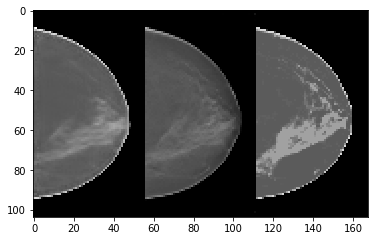

In [56]:
index = random.randint(0, 35)
print(index)
plt.imshow(np.concatenate([result[index, :, :, 20, 0], valx[index, :, :, 20, 0], valy[index, :, :, 20, 0]], axis=-1), cmap='gray')

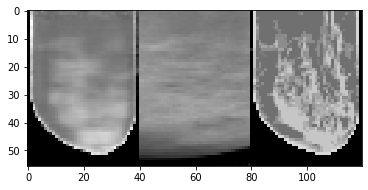

In [73]:
index = random.randint(0, 35)
plt.imshow(np.concatenate([result[index, 50, :, :, 0], valx[index, 50, :, :, 0], valy[index, 50, :, :, 0]], axis=-1), cmap='gray')